In [1]:
# https://medium.com/@murrawang/deep-q-network-and-its-application-in-algorithmic-trading-16440a112e04
# https://github.com/Murraaa11/Algorithmic-Trading-with-DQN/tree/main

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Comp579_Project/DQN')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
import os
import gym
import torch
import numpy as np
import random
import yfinance as yf
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import numpy as np

from dqn_custom import DQN_Agent
from trading_env import TradingSystem
from utils import train, test, Config

In [4]:
random.seed(11)

cfg = Config()

# Define the tickers and the time range
start_date = dt.date(2020, 1, 1)
end_date = dt.datetime.today().strftime ('%Y-%m-%d')
train_tickers = ['ZM','MTCH','GOOG','PINS','SNAP','ETSY']
test_tickers = ['IAC','BMBL','SOCL']

In [5]:
def env_agent_config(data, cfg, mode):
    ''' create environment and agent
    '''
    env = TradingSystem(data, cfg.state_space_dim, mode)
    agent = DQN_Agent(cfg.state_space_dim, cfg.action_space_dim, cfg)
    if cfg.seed != 0:  # set random seeds
        torch.manual_seed(cfg.seed)
        np.random.seed(cfg.seed)
    return env, agent

In [6]:
# download stock data from yahoo finance
train_data = {}
for ticker in train_tickers:
    data = yf.download(ticker, start_date, end_date)
    returns = data['Adj Close'].pct_change()[1:]
    train_data[ticker] = returns

test_data = {}
for ticker in test_tickers:
    data = yf.download(ticker, start_date, end_date)
    returns = data['Adj Close'].pct_change()[1:]
    test_data[ticker] = returns

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Start Training!
Environment：TradingSystem, Algorithm：DQN, Device：cuda
Episode：10/200, Reward：0.5781104838785425
Episode：20/200, Reward：1.0513143006545267
Episode：30/200, Reward：4.6534073905082245
Episode：40/200, Reward：4.7715481084463605
Episode：50/200, Reward：2.0950755690297296
Episode：60/200, Reward：2.141204093978904
Episode：70/200, Reward：2.6041573730550294
Episode：80/200, Reward：2.750266950893093
Episode：90/200, Reward：6.623380752774745
Episode：100/200, Reward：5.267342413289638
Episode：110/200, Reward：5.329801968838133
Episode：120/200, Reward：6.02675832583804
Episode：130/200, Reward：8.538521644987334
Episode：140/200, Reward：7.382775379750887
Episode：150/200, Reward：9.422924640772425
Episode：160/200, Reward：3.0679471175817863
Episode：170/200, Reward：3.5210049249201383
Episode：180/200, Reward：10.799567050993836
Episode：190/200, Reward：3.4441726971419095
Episode：200/200, Reward：3.530637860848665
Finish Training!


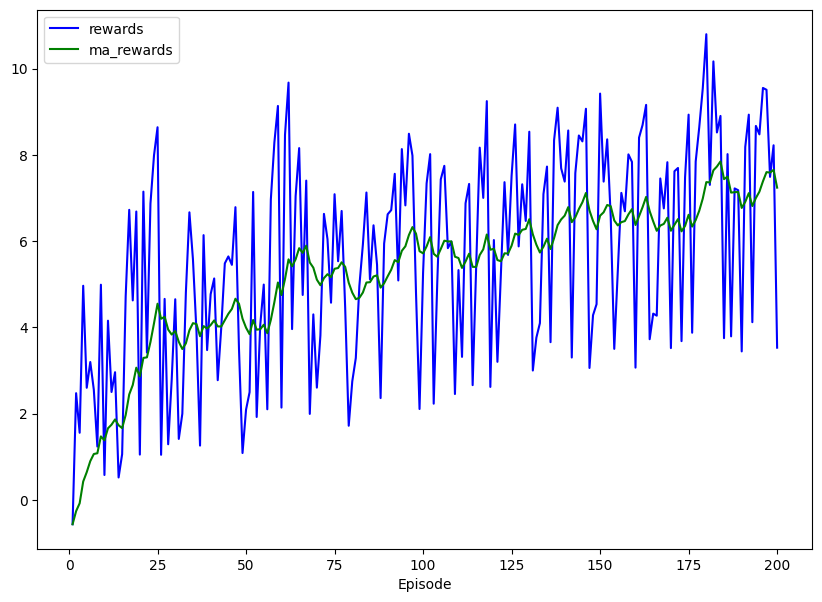

In [7]:
# training
env, agent = env_agent_config(train_data, cfg, 'train')
rewards, ma_rewards = train(cfg, env, agent)
os.makedirs(cfg.result_path)  # create output folders
os.makedirs(cfg.model_path)
agent.save(path=cfg.model_path)  # save model

# plot the training result
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(list(range(1, cfg.train_eps+1)), rewards, color='blue', label='rewards')
ax.plot(list(range(1, cfg.train_eps+1)), ma_rewards, color='green', label='ma_rewards')
ax.legend()
ax.set_xlabel('Episode')
plt.savefig(cfg.result_path+'train.jpg')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Start Testing!
Environment：TradingSystem, Algorithm：DQN, Device：cuda
Episode：1/9，Reward：7.3
Episode：2/9，Reward：8.3
Episode：3/9，Reward：4.4
Episode：4/9，Reward：10.0
Episode：5/9，Reward：9.7
Episode：6/9，Reward：9.1
Episode：7/9，Reward：2.3
Episode：8/9，Reward：2.7
Episode：9/9，Reward：2.7
Finish Testing!


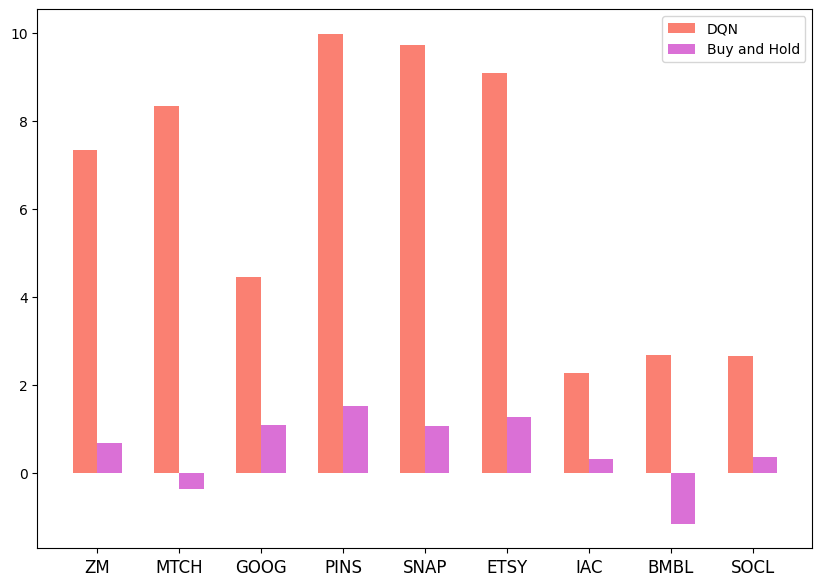

In [8]:
# testing
all_data = {**train_data, **test_data}
env, agent = env_agent_config(all_data, cfg, 'test')
agent.load(path=cfg.model_path)  # load model
stocks, rewards = test(cfg, env, agent)
buy_and_hold_rewards = [sum(all_data[stock]) for stock in stocks]

# plot the test result
fig, ax = plt.subplots(1, 1, figsize=(10, 7))  # plot the test result
width = 0.3
x = np.arange(len(stocks))
ax.bar(x, rewards, width=width, color='salmon', label='DQN')
ax.bar(x+width, buy_and_hold_rewards, width=width, color='orchid', label='Buy and Hold')
ax.set_xticks(x+width/2)
ax.set_xticklabels(stocks, fontsize=12)
ax.legend()
plt.savefig(cfg.result_path+'test.jpg')